# Evaluation of Batch Effect Correction
This notebook asks whether batch effect correction works for correcting inter-study differences and/or interplatform differences.

In [1]:
import collections
import json
import os
import pickle
from typing import Text, Dict, Union, List

import pandas as pd
import sklearn
from plotnine import ggplot, geom_point, aes
from tqdm.notebook import tqdm

from saged import utils

In [2]:
def return_unlabeled():
    # For use in a defaultdict
    return 'unlabeled'

In [3]:
data_dir = '../../data/'
map_file = os.path.join(data_dir, 'sample_classifications.pkl')

sample_to_label = utils.parse_map_file(map_file)
sample_to_label = collections.defaultdict(return_unlabeled, sample_to_label)

with open(map_file, 'rb') as in_file:
    label_to_sample = pickle.load(in_file)[0]

In [4]:
metadata_path = os.path.join(data_dir, 'aggregated_metadata.json')
metadata = None
with open(metadata_path) as json_file:
    metadata = json.load(json_file)

## Get blood samples from dataset


In [5]:
sample_ids = utils.get_blood_sample_ids(metadata, sample_to_label)
print(len(sample_ids))

29934


In [6]:
compendium_path = os.path.join(data_dir, 'HOMO_SAPIENS.tsv')                                                             

# Not all labeled samples show up in the compendium, which causes pandas to panic. To fix this  
# we have to take the intersection of the accessions in sample_ids and the accessions in the       
# compendium                                                                                    
header_ids = None                                                                               
with open(compendium_path) as in_file:                                                          
    header = in_file.readline()                                                                 
    header_ids = header.split('\t')                                                             

valid_sample_ids = [id_ for id_ in sample_ids if id_ in header_ids]  
valid_sample_ids = set(valid_sample_ids)
print(len(valid_sample_ids))

29235


## Read in expression data
Now that we know which samples we're interested in, let's read those samples from the compendium.
This is doable with pandas, but subsetting a dataframe is extremely slow for some reason.
Manually writing the subsetted tsv to a file and loading it should be substantially faster and
less memory intensive

In [7]:
out_path = os.path.join(data_dir, 'subset_compendium.tsv')

In [8]:
with open(compendium_path) as compendium_file:
    with open(out_path, 'w') as out_file:
        header = compendium_file.readline().strip().split('\t')
        # Start with zero included to keep all gene names
        col_indices_to_keep = [i+1 for i in range(len(header)) if header[i] in valid_sample_ids]
        col_indices_to_keep = [0] + col_indices_to_keep
        
        # Print header, keeping empty index column as in the original compendium
        header = [''] + header
        # You can't index a list with a list of indices in python, so we have to 
        # Use the __getitem__ function for each index
        header_string = '\t'.join(map(header.__getitem__, col_indices_to_keep))
        out_file.write('{}\n'.format(header_string))
        
        for line in tqdm(compendium_file):
            line = line.strip().split('\t')
            out_string = '\t'.join(map(line.__getitem__, col_indices_to_keep))
            out_file.write('{}\n'.format(out_string))
            

In [9]:
compendium_df = pd.read_csv(out_path, sep='\t', index_col=0)

### Get Sample Metadata

In [10]:
experiments = metadata['experiments']
sample_to_study = {}
for study in experiments:
    for accession in experiments[study]['sample_accession_codes']:
        sample_to_study[accession] = study

### Create PCA Embedding of all data

In [11]:
reducer = sklearn.decomposition.PCA(n_components=2)
compendium_df = compendium_df.transpose()
pca_embedding = reducer.fit_transform(compendium_df.values)
print(reducer.explained_variance_ratio_)

pca_embedding.shape

[0.21454787 0.11023142]


(29235, 2)

In [12]:
compendium_df.head()

ENSG00000000003  ENSG00000000005  ENSG00000000419  \
E-MEXP-1635-04SE57HA300104         0.208914        -0.060592         6.833205   
E-MEXP-1635-04SE58HA300104         0.247681        -0.057062         9.714408   
E-MEXP-1635-04SE59HA300104         0.133060        -0.015866         9.193253   
E-MEXP-1635-04SE60HA300104         0.225220        -0.076875        10.588144   
E-MEXP-1635-04SE61HA300104         0.225110        -0.011201        10.091911   

                            ENSG00000000457  ENSG00000000460  ENSG00000000938  \
E-MEXP-1635-04SE57HA300104         0.214447        -0.057339        14.716667   
E-MEXP-1635-04SE58HA300104         0.087237        -0.034758        15.627227   
E-MEXP-1635-04SE59HA300104         0.402771        -0.043255        10.489084   
E-MEXP-1635-04SE60HA300104         0.209681        -0.078963        10.081331   
E-MEXP-1635-04SE61HA300104         0.141353        -0.096355        10.690051   

                            ENSG00000000971  ENSG00000001036  ENSG00000001084  \
E-MEXP-1635-04SE57HA300104         0.333249         1.973349         2.481825   
E-MEXP-1635-04SE58HA300104         0.560429         1.990947         2.728084   
E-MEXP-1635-04SE59HA300104         0.407717         1.853691         2.586305   
E-MEXP-1635-04SE60HA300104         0.665616         2.025645         2.366040   
E-MEXP-1635-04SE61HA300104         0.417136         2.019385         2.557729   

                            ENSG00000001167  ...  ENSG00000278845  \
E-MEXP-1635-04SE57HA300104         1.198605  ...         3.556903   
E-MEXP-1635-04SE58HA300104         1.006605  ...         3.503867   
E-MEXP-1635-04SE59HA300104         0.707855  ...         3.535144   
E-MEXP-1635-04SE60HA300104         0.990498  ...         3.440013   
E-MEXP-1635-04SE61HA300104         0.981246  ...         3.470510   

                            ENSG00000278921  ENSG00000279324  ENSG00000279364  \
E-MEXP-1635-04SE57HA300104        -0.150116         0.075878        -0.197360   
E-MEXP-1635-04SE58HA300104        -0.140382         0.015777        -0.158905   
E-MEXP-1635-04SE59HA300104        -0.160516         0.111114        -0.194840   
E-MEXP-1635-04SE60HA300104        -0.118642         0.089987        -0.164568   
E-MEXP-1635-04SE61HA300104        -0.135320        -0.032727        -0.142403   

                            ENSG00000279636  ENSG00000280109  ENSG00000280237  \
E-MEXP-1635-04SE57HA300104         0.250837         1.343591         0.893074   
E-MEXP-1635-04SE58HA300104         0.222942         1.278304         0.866655   
E-MEXP-1635-04SE59HA300104         0.102308         0.877241         0.893358   
E-MEXP-1635-04SE60HA300104         0.233276         0.850390         0.701288   
E-MEXP-1635-04SE61HA300104         0.163395         0.908470         0.890081   

                            ENSG00000282988  ENSG00000283597  ENSG00000283632  
E-MEXP-1635-04SE57HA300104        -0.148781        -0.134957         1.630485  
E-MEXP-1635-04SE58HA300104        -0.141766        -0.160663         1.456953  
E-MEXP-1635-04SE59HA300104        -0.138150        -0.157599         1.304510  
E-MEXP-1635-04SE60HA300104        -0.054042        -0.153946         1.290186  
E-MEXP-1635-04SE61HA300104        -0.170989        -0.166252         1.437998  

[5 rows x 14634 columns]

In [13]:
embedding_df = pd.DataFrame.from_dict({'sample': list(compendium_df.index),
                                       'pc1': list(pca_embedding[:,0]),
                                       'pc2': list(pca_embedding[:,1]),
                                      })

In [14]:
sample_metadata = metadata['samples']

platforms = []
for sample in embedding_df['sample']:
    platforms.append(sample_metadata[sample]['refinebio_platform'].lower())
    
embedding_df['platform'] = platforms

In [15]:
embedding_df['study'] = embedding_df['sample'].map(sample_to_study)
embedding_df['label'] = embedding_df['sample'].map(sample_to_label)

In [16]:
embedding_df.head()

sample         pc1         pc2  \
0  E-MEXP-1635-04SE57HA300104 -204.746193  209.124117   
1  E-MEXP-1635-04SE58HA300104 -199.125607  160.140664   
2  E-MEXP-1635-04SE59HA300104 -217.131800  213.467357   
3  E-MEXP-1635-04SE60HA300104 -204.439660  208.940541   
4  E-MEXP-1635-04SE61HA300104 -205.979391  176.295667   

                                        platform        study    label  
0  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy  
1  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy  
2  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy  
3  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy  
4  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy

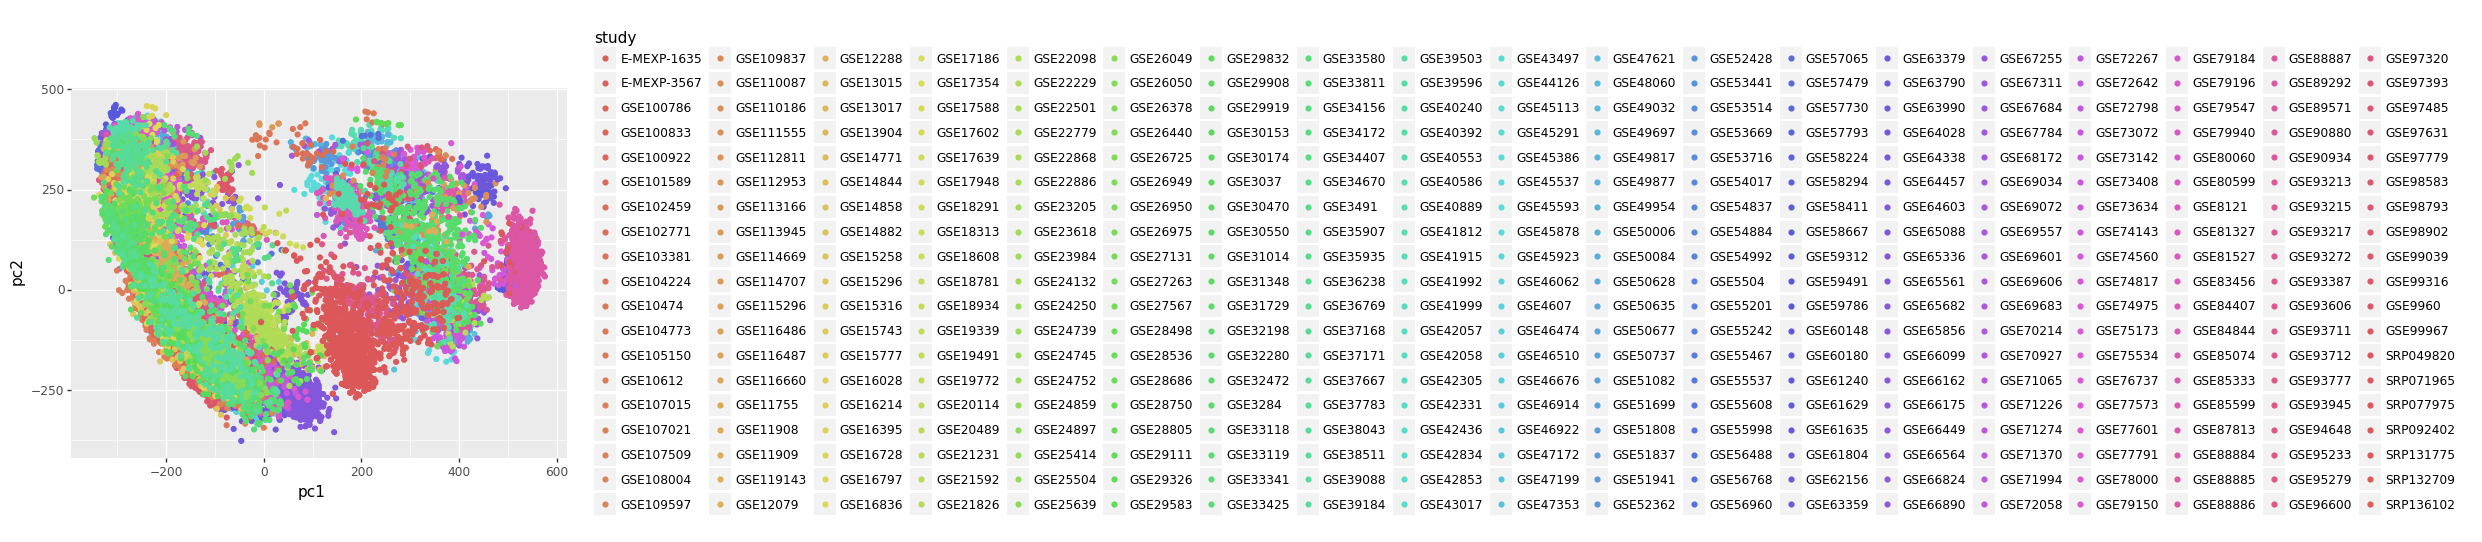

<ggplot: (8773320672907)>

In [17]:
ggplot(embedding_df, aes(x='pc1', y='pc2', color='study')) + geom_point()

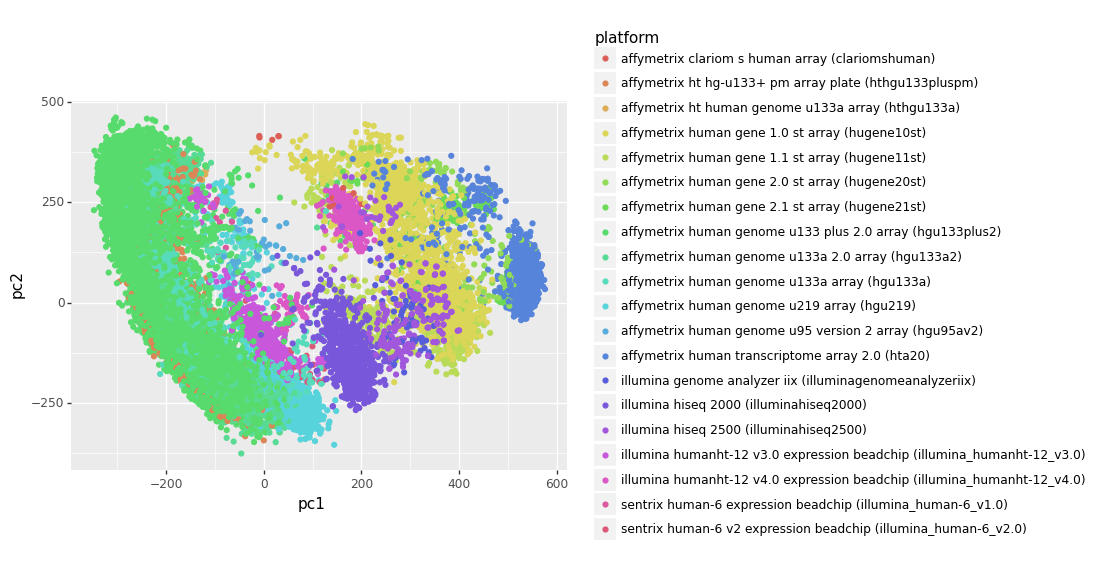

<ggplot: (8773310250379)>

In [18]:
ggplot(embedding_df, aes(x='pc1', y='pc2', color='platform')) + geom_point()

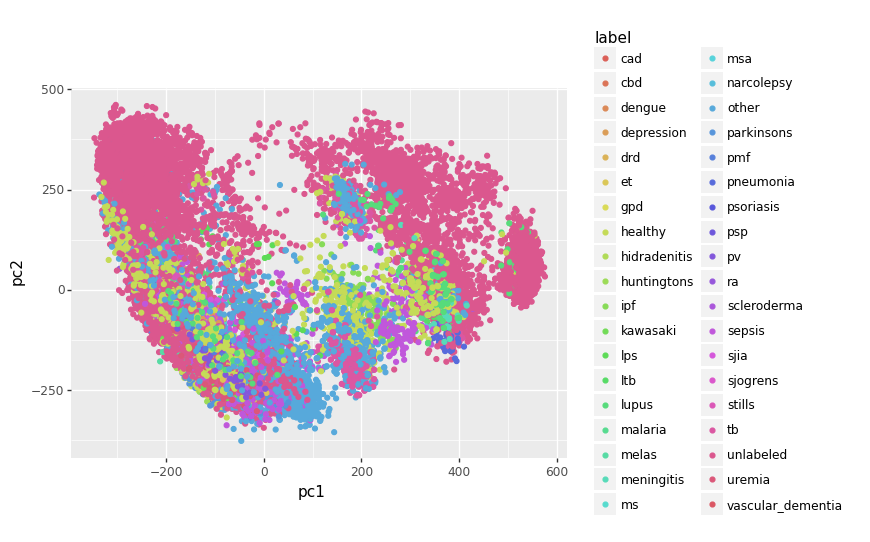

<ggplot: (8773297931789)>

In [19]:
ggplot(embedding_df, aes(x='pc1', y='pc2', color='label')) + geom_point()

In [20]:
study_vector = embedding_df['study'].values
platform_vector = embedding_df['platform'].values

In [21]:
%load_ext rpy2.ipython

In [22]:
expression_values = compendium_df.transpose().values

In [23]:
expression_values.shape

(14634, 29235)

## Correct batches with limma

In [24]:
study_corrected = utils.run_limma(expression_values, study_vector)
platform_corrected = utils.run_limma(expression_values, platform_vector)
full_corrected = utils.run_limma(expression_values, study_vector, platform_vector)

Coefficients not estimable: batch22 batch23 batch24 batch25 batch26 batch27 batch211 batch212 batch213 batch215 batch216 batch217 batch218 batch219 


In [25]:
# Run batch effect correction
# Create PCA embedding of corrected data
# Add to the dataframe
# Plot and compare uncorrected and batch corrected 
study_corrected = study_corrected.transpose()
platform_corrected = platform_corrected.transpose()
full_corrected = full_corrected.transpose()

In [26]:
study_corrected_pcs = reducer.fit_transform(study_corrected)
print(reducer.explained_variance_ratio_)
platform_corrected_pcs = reducer.fit_transform(platform_corrected)
print(reducer.explained_variance_ratio_)
full_corrected_pcs = reducer.fit_transform(full_corrected)
print(reducer.explained_variance_ratio_)

[0.08819928 0.07643336]
[0.17541126 0.08797506]
[0.08835467 0.07656355]


In [27]:
embedding_df['study_pc1'] = study_corrected_pcs[:,0]
embedding_df['study_pc2'] = study_corrected_pcs[:,1]
embedding_df['platform_pc1'] = platform_corrected_pcs[:,0]
embedding_df['platform_pc2'] = platform_corrected_pcs[:,1]
embedding_df['full_correction_pc1'] = full_corrected_pcs[:,0]
embedding_df['full_correction_pc2'] = full_corrected_pcs[:,1]

In [28]:
embedding_df.head()

sample         pc1         pc2  \
0  E-MEXP-1635-04SE57HA300104 -204.746193  209.124117   
1  E-MEXP-1635-04SE58HA300104 -199.125607  160.140664   
2  E-MEXP-1635-04SE59HA300104 -217.131800  213.467357   
3  E-MEXP-1635-04SE60HA300104 -204.439660  208.940541   
4  E-MEXP-1635-04SE61HA300104 -205.979391  176.295667   

                                        platform        study    label  \
0  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy   
1  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy   
2  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy   
3  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy   
4  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy   

   study_pc1  study_pc2  platform_pc1  platform_pc2  full_correction_pc1  \
0 -24.140288  -0.218049    208.583667    -16.972871           -24.122942   
1  10.532612   0.346097    164.095737    -38.896656            10.555942   
2 -70.675626  11.954303    226.949985     -9.016933           -70.674677   
3 -20.066303  10.359830    212.003329    -10.933293           -20.069345   
4  -0.198636  24.950357    176.764652     -4.259910            -0.221992   

   full_correction_pc2  
0            -0.265617  
1             0.326562  
2            11.885279  
3            10.314676  
4            24.930362

## Plot by platform

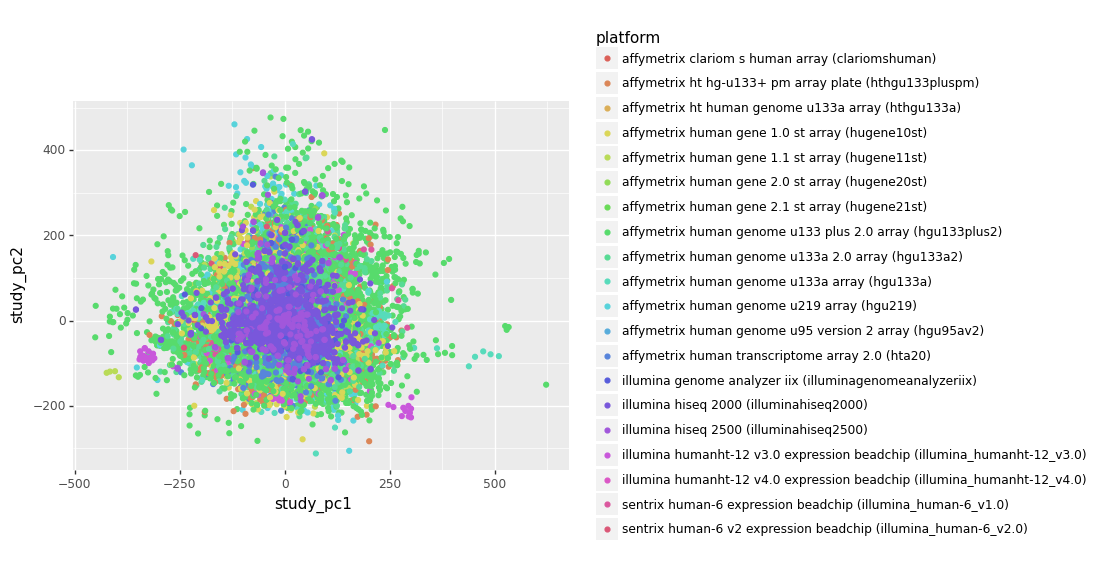

<ggplot: (8773304603926)>

In [29]:
ggplot(embedding_df, aes(x='study_pc1', y='study_pc2', color='platform')) + geom_point()

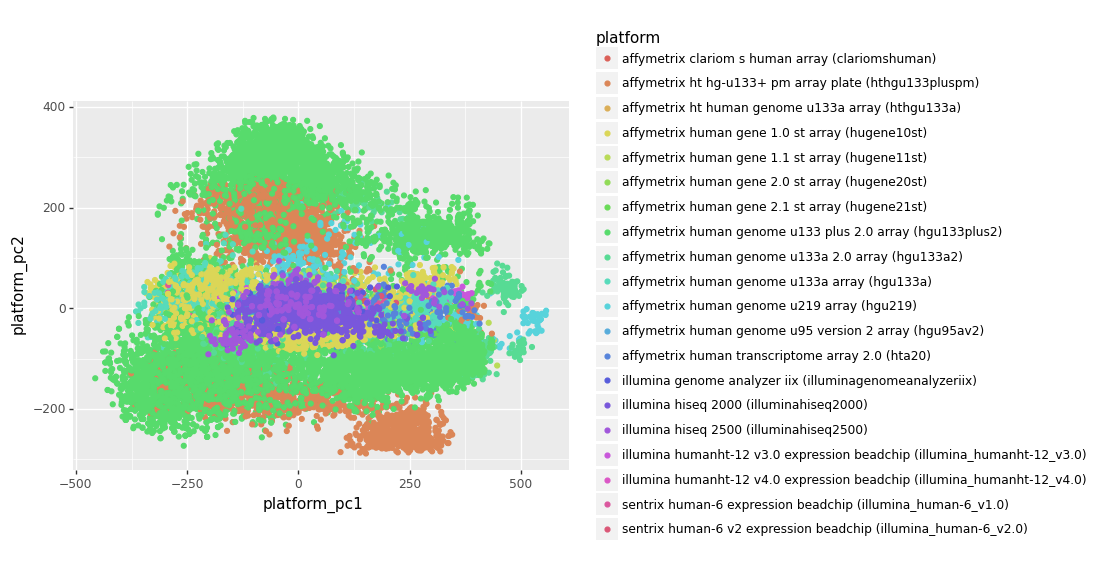

<ggplot: (8773284774708)>

In [30]:
ggplot(embedding_df, aes(x='platform_pc1', y='platform_pc2', color='platform')) + geom_point()

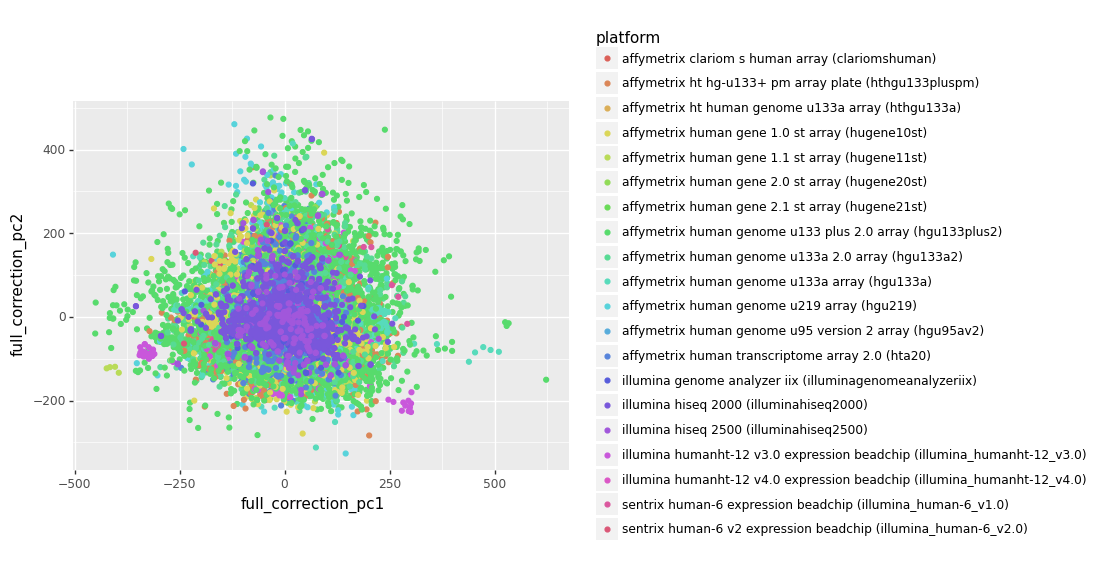

<ggplot: (8773306077618)>

In [31]:
ggplot(embedding_df, aes(x='full_correction_pc1', y='full_correction_pc2', color='platform')) + geom_point()

## Plot by study

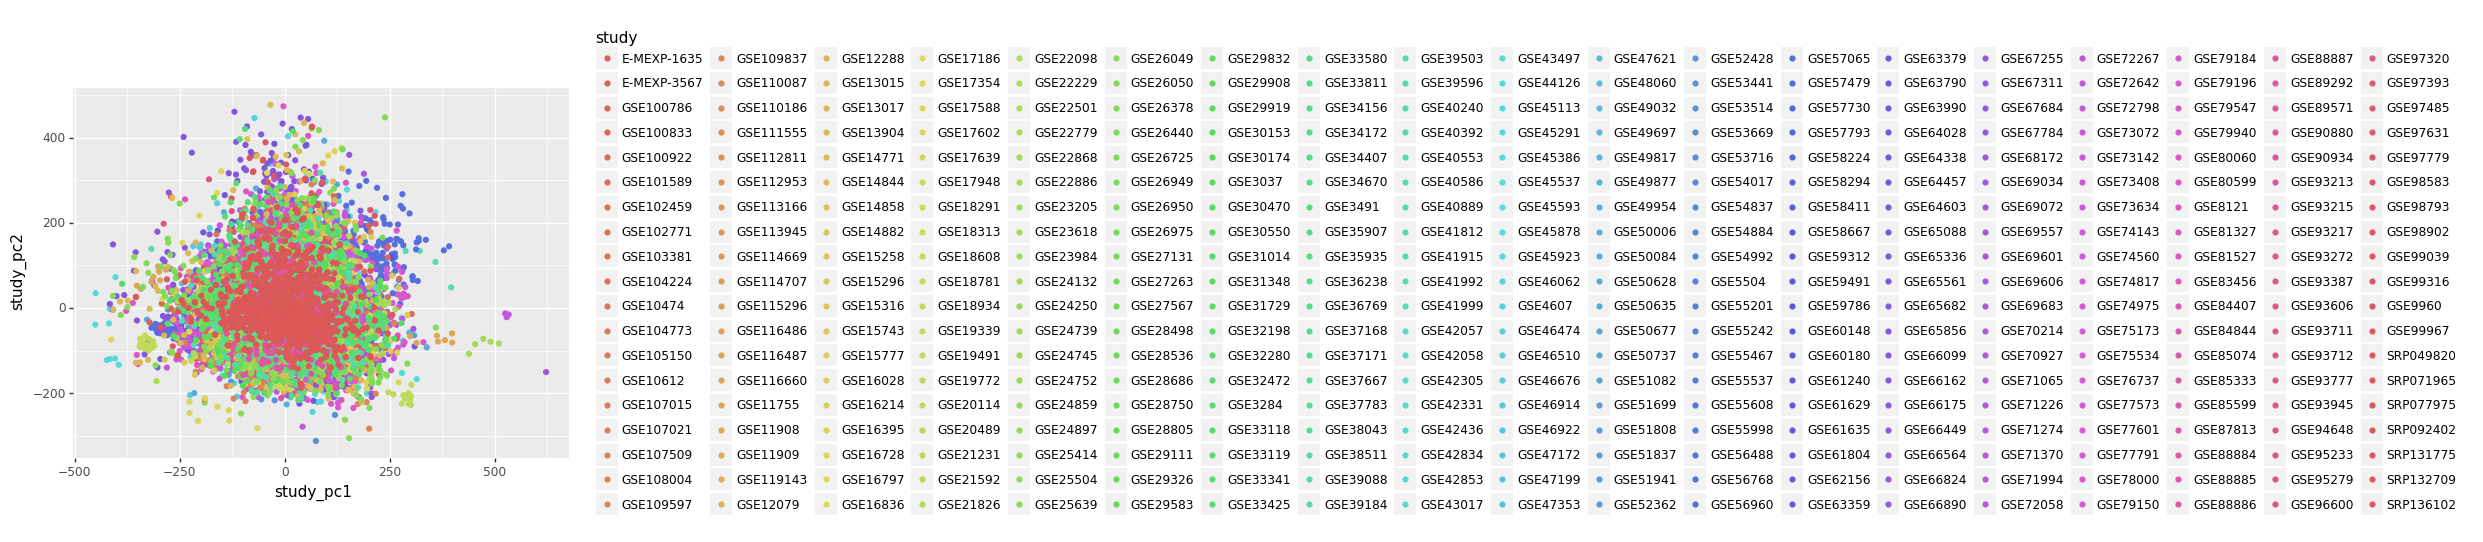

<ggplot: (8773277474012)>

In [32]:
ggplot(embedding_df, aes(x='study_pc1', y='study_pc2', color='study')) + geom_point()

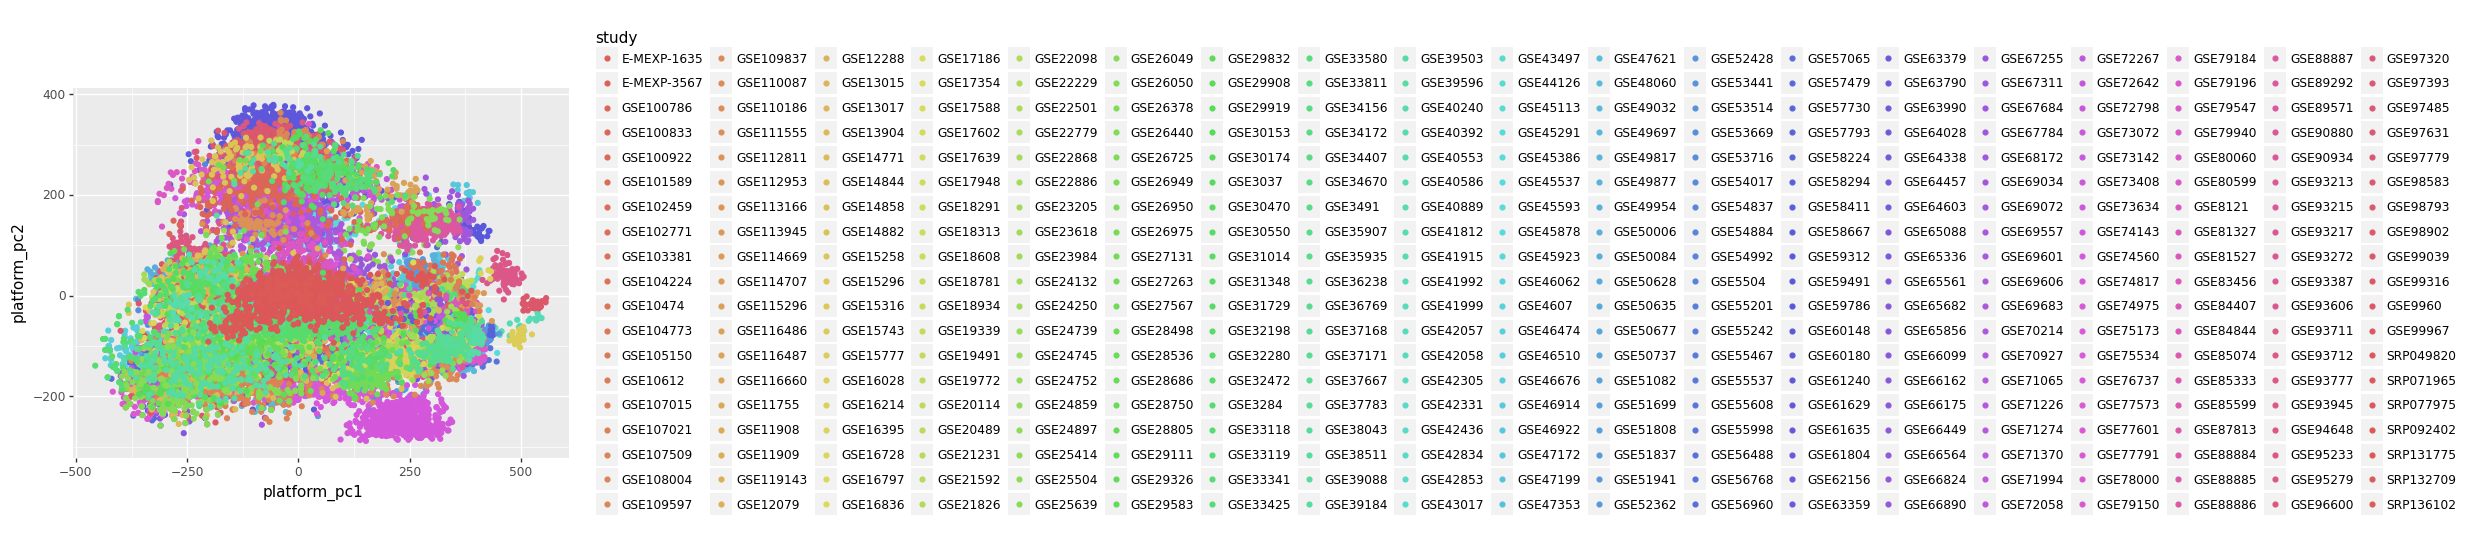

<ggplot: (8773297105866)>

In [33]:
ggplot(embedding_df, aes(x='platform_pc1', y='platform_pc2', color='study')) + geom_point()

## Plot by label

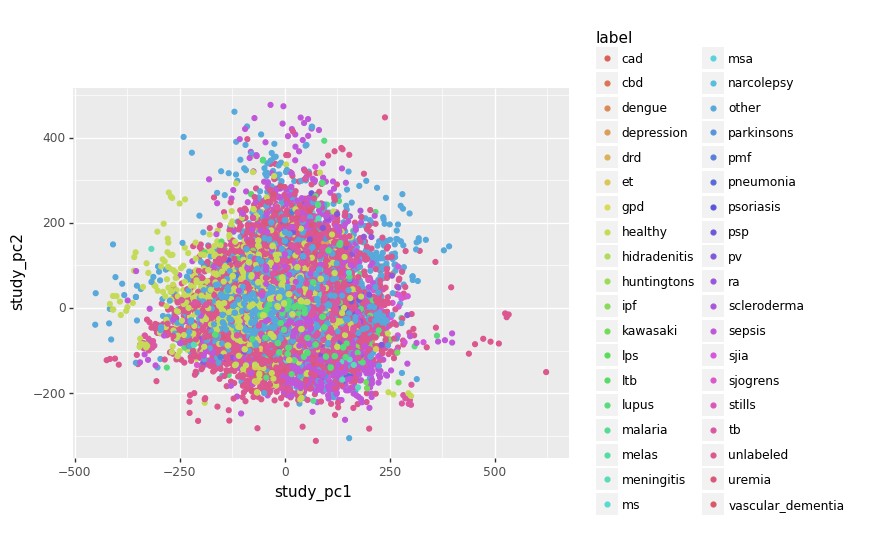

<ggplot: (8773263073759)>

In [34]:
ggplot(embedding_df, aes(x='study_pc1', y='study_pc2', color='label')) + geom_point()

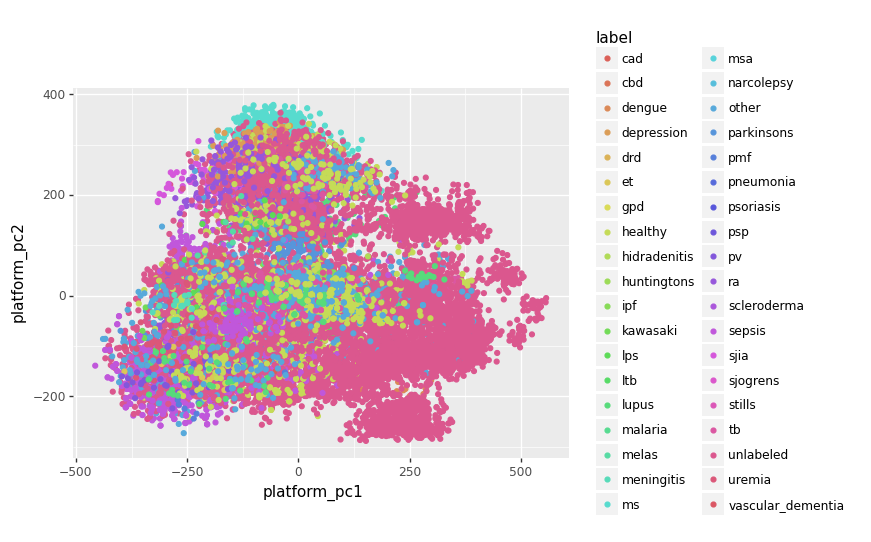

<ggplot: (8773242418821)>

In [35]:
ggplot(embedding_df, aes(x='platform_pc1', y='platform_pc2', color='label')) + geom_point()

## Limma Results
It looks like Limma does a good job of correcting for batch effects, but may overcorrect, especiall when accounting for all studies.

It's also worth noting that due to the tendancy of a study to use only one platform, correcting for study and platform is redundant

## Correct batches with ComBat

In [36]:
study_corrected = utils.run_combat(expression_values, study_vector)
platform_corrected = utils.run_combat(expression_values, platform_vector)

R[write to console]: Found361batches

R[write to console]: Note: one batch has only one sample, setting mean.only=TRUE

R[write to console]: Adjusting for0covariate(s) or covariate level(s)



Standardizing Data across genes


R[write to console]: Fitting L/S model and finding priors

R[write to console]: Finding parametric adjustments

R[write to console]: Adjusting the Data


R[write to console]: Found20batches

R[write to console]: Adjusting for0covariate(s) or covariate level(s)



Standardizing Data across genes


R[write to console]: Fitting L/S model and finding priors

R[write to console]: Finding parametric adjustments

R[write to console]: Adjusting the Data




In [37]:
study_corrected = study_corrected.transpose()
platform_corrected = platform_corrected.transpose()

In [38]:
study_corrected_pcs = reducer.fit_transform(study_corrected)
print(reducer.explained_variance_ratio_)
platform_corrected_pcs = reducer.fit_transform(platform_corrected)
print(reducer.explained_variance_ratio_)

[0.10322433 0.07681086]
[0.19085307 0.07296351]


In [39]:
embedding_df['study_pc1'] = study_corrected_pcs[:,0]
embedding_df['study_pc2'] = study_corrected_pcs[:,1]
embedding_df['platform_pc1'] = platform_corrected_pcs[:,0]
embedding_df['platform_pc2'] = platform_corrected_pcs[:,1]

In [40]:
embedding_df.head()

sample         pc1         pc2  \
0  E-MEXP-1635-04SE57HA300104 -204.746193  209.124117   
1  E-MEXP-1635-04SE58HA300104 -199.125607  160.140664   
2  E-MEXP-1635-04SE59HA300104 -217.131800  213.467357   
3  E-MEXP-1635-04SE60HA300104 -204.439660  208.940541   
4  E-MEXP-1635-04SE61HA300104 -205.979391  176.295667   

                                        platform        study    label  \
0  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy   
1  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy   
2  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy   
3  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy   
4  affymetrix human genome u133a array (hgu133a)  E-MEXP-1635  healthy   

    study_pc1  study_pc2  platform_pc1  platform_pc2  full_correction_pc1  \
0 -134.873621  53.004187    193.891964    -10.018128           -24.122942   
1 -102.862688  18.661923    155.305947    -25.586140            10.555942   
2 -161.322588  52.708780    219.684377     10.094259           -70.674677   
3 -129.578936  51.141993    204.175485     -4.858555           -20.069345   
4 -111.745393  28.467403    177.038817      4.143130            -0.221992   

   full_correction_pc2  
0            -0.265617  
1             0.326562  
2            11.885279  
3            10.314676  
4            24.930362

## Plot by platform

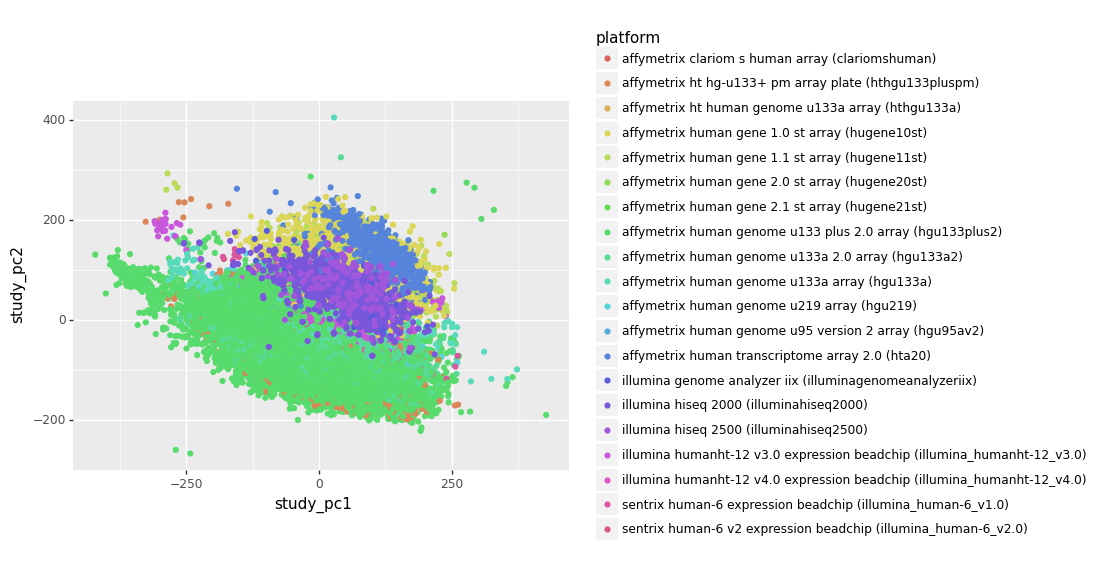

<ggplot: (8773259943286)>

In [41]:
ggplot(embedding_df, aes(x='study_pc1', y='study_pc2', color='platform')) + geom_point()

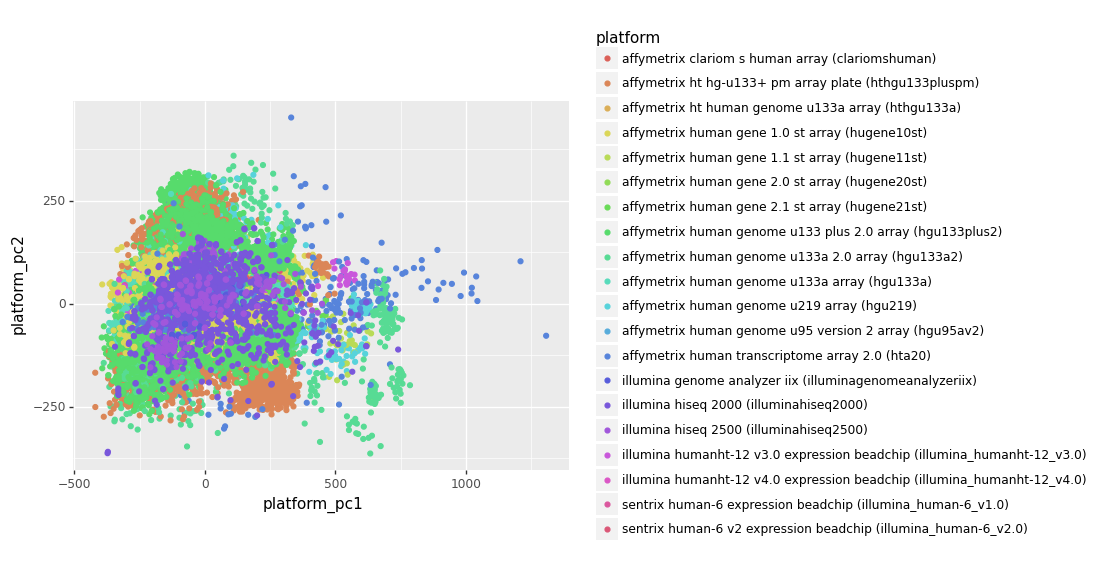

<ggplot: (8773243244011)>

In [42]:
ggplot(embedding_df, aes(x='platform_pc1', y='platform_pc2', color='platform')) + geom_point()

## Plot by study

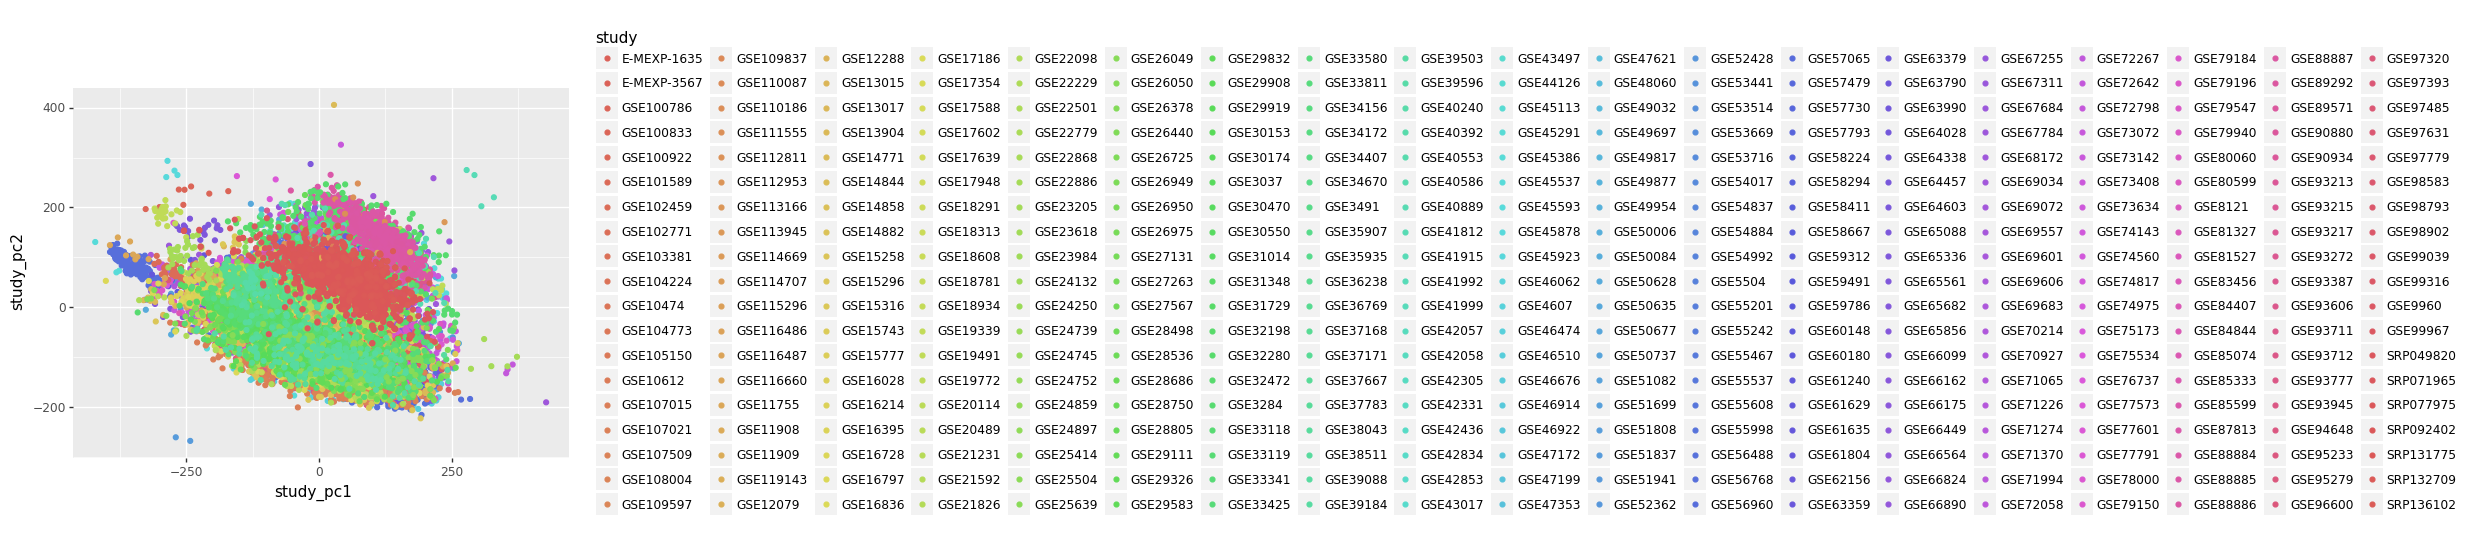

<ggplot: (8773284774726)>

In [43]:
ggplot(embedding_df, aes(x='study_pc1', y='study_pc2', color='study')) + geom_point()

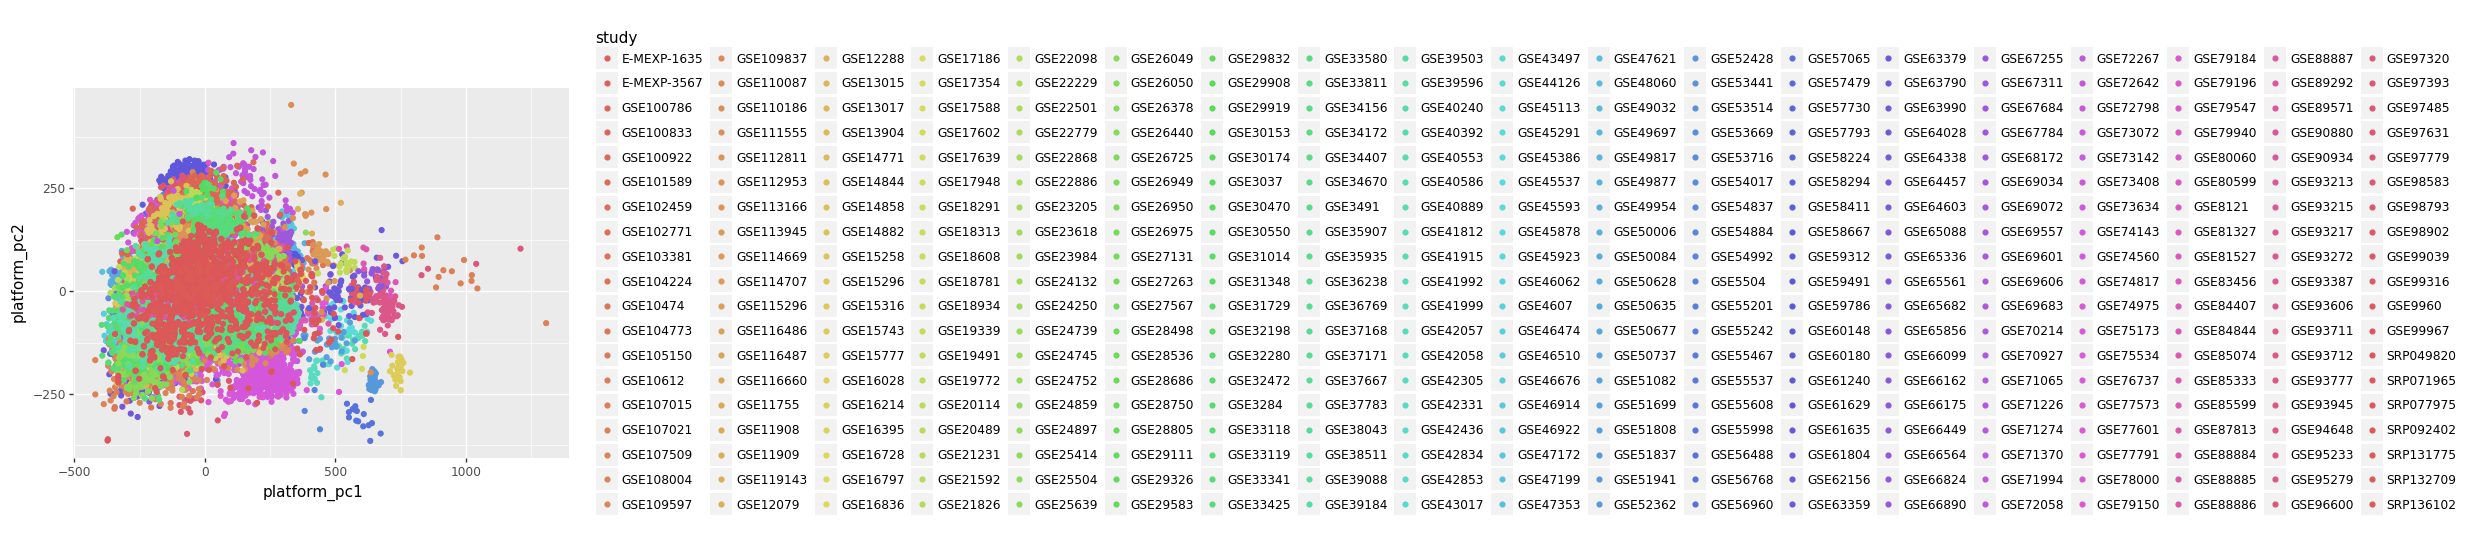

<ggplot: (8773238230547)>

In [44]:
ggplot(embedding_df, aes(x='platform_pc1', y='platform_pc2', color='study')) + geom_point()

## Plot by label

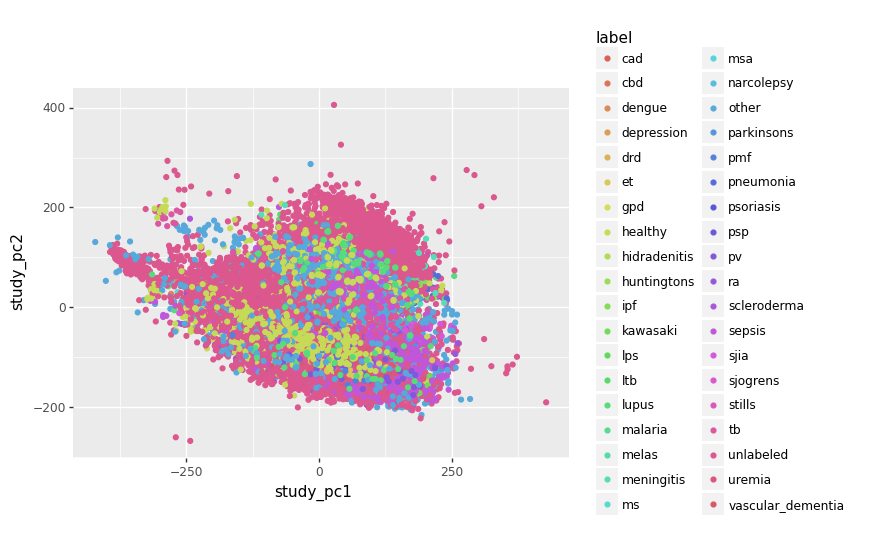

<ggplot: (8773321027853)>

In [45]:
ggplot(embedding_df, aes(x='study_pc1', y='study_pc2', color='label')) + geom_point()

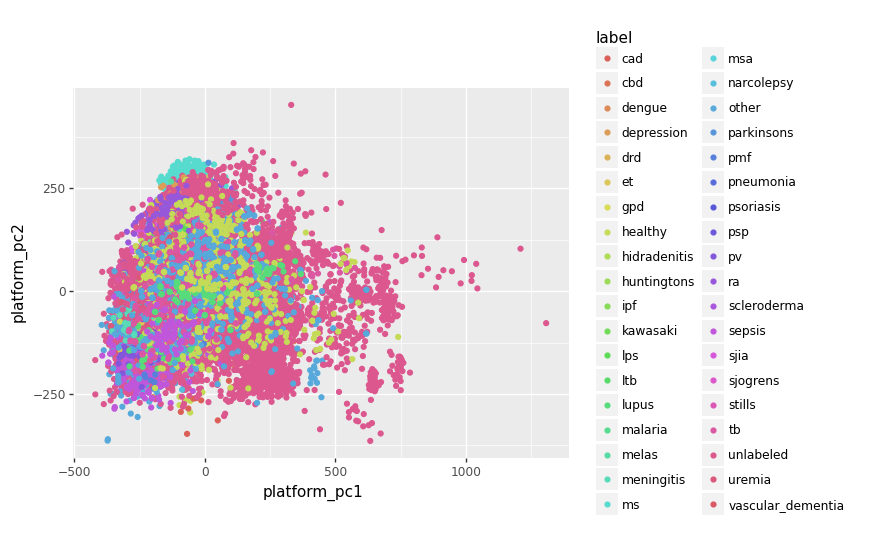

<ggplot: (8773321687962)>

In [46]:
ggplot(embedding_df, aes(x='platform_pc1', y='platform_pc2', color='label')) + geom_point()

## ComBat Conclusions
Combat appears to correct less severely than Limma does. As a result the labels look more separable after correction, but there also appears to be lingering interplatform differences after study and platform correction